# Импорт

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score
from typing import Dict, List, Union
import joblib

In [3]:
df = pd.read_parquet('/Users/vitaly/Developer/Study/HSE/hse-habr2024/ML_baseline/df_l_fin.parquet')

In [4]:
df.head()

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,tags_tokens,title_tokens,rating_new,text_tokens,text_pos_tags
0,complex,2009-08-03 14:34:35+00:00,GTD,67,6800,https://habr.com/ru/articles/66091/,2.0,individual,25.0,2027,['лень' 'учись' 'работать' 'самомотивация' 'мо...,['лечение' 'приступ' 'лень'],4.0,['лишать' 'девственность' 'бложик' 'происходит...,"[NOUN, VERB, NOUN, DET, NOUN, ADV, SCONJ, PRON..."
1,popotam2,2009-07-15 20:24:31+00:00,GTD,13,3100,https://habr.com/ru/articles/64586/,1.0,individual,6.0,424,['развитие' 'работоспособность' 'организация' ...,['организация' 'рабочий' 'время' 'помощь' 'цвет'],1.0,['предлагать' 'вариант' 'сделать' 'организован...,"[VERB, ADV, NUM, NOUN, VERB, PRON, ADV, ADJ, C..."
2,COOL_ALMANAH,2009-05-13 11:37:50+00:00,GTD,22,1300,https://habr.com/ru/articles/59477/,1.0,individual,6.0,1084,['flash' 'работа' 'время' 'контроль' 'шахматны...,['контроль' 'потерять' 'время' 'flash' 'обновл...,4.0,['таймер' 'обновиться' 'надеяться' 'удобный' '...,"[NOUN, VERB, SPACE, ADV, PRON, VERB, AUX, ADJ,..."
3,ZakharS,2009-05-14 11:13:12+00:00,GTD,314,6700,https://habr.com/ru/articles/59584/,5.0,individual,104.0,7852,['карьера' 'it' 'финансы' 'рост'],['достигнуть' 'потолок' 'зарплата'],147.0,['предупредить' 'несмотря' 'экран' 'текст' 'ст...,"[VERB, ADV, VERB, PRON, ADV, ADP, NUM, NOUN, N..."
4,Kerf,2009-03-19 14:44:04+00:00,GTD,3,892,https://habr.com/ru/articles/54970/,6.0,individual,16.0,8872,['бизнес' 'корпорация' 'вебдизайн' 'контент'],['вещь' 'знать' 'клиент'],3.0,['когдалибо' 'чувствовать' 'бесконечно' 'повто...,"[PRON, PRON, VERB, SCONJ, PRON, ADV, VERB, DET..."


In [5]:
# Уберем слишком короткие (неинформативные) статьи
display(df['text_length'].describe())
df = df[df['text_length']>100].copy()
df['text_length'].describe()

count    284895.000000
mean       7571.855771
std        7980.117174
min           1.000000
25%        2104.000000
50%        5514.000000
75%       10315.000000
max      197359.000000
Name: text_length, dtype: float64

count    282640.000000
mean       7631.863576
std        7983.445597
min         101.000000
25%        2168.000000
50%        5575.000000
75%       10372.000000
max      197359.000000
Name: text_length, dtype: float64

# Создание таргета

In [6]:
# Выделение шкалы оценок на основе рейтинга статьи,
# Это будет таргет для предсказания оценки статьи
neg_d = df[df['rating_new']<0]['rating_new'].describe()
pos_d = df[df['rating_new']>0]['rating_new'].describe()

def rating_func(row):
    rate = row['rating_new']

    if pos_d['25%'] >= rate >= neg_d['75%']:
        return('neutral')
    
    elif pos_d['75%'] >= rate > pos_d['25%']:
        return('positive')
    elif rate > pos_d['75%']:
        return('very positive')
    
    elif neg_d['75%'] > rate >= neg_d['25%']:
        return('negative')
    elif neg_d['25%'] > rate:
        return('very negative')
    
df['rating_level'] = df.apply(rating_func, axis=1)

In [7]:
# Объединяем текстовые токены в единую строку, 
# Это будет наш главный признак для предсказания тем (хабов) статей
df['text_combined'] = df['text_tokens'] + ' ' + df['title_tokens'] + ' ' + df['tags_tokens']

# Сразу удалим ненужные столбцы для облегчения вычислений
df = df.drop(columns=['tags_tokens', 'title_tokens', 'text_tokens']).copy()

In [8]:
# Извлекаем уникальные метки из тегов
unique_labels = set()
df['hubs'].str.split(', ').apply(unique_labels.update)  # Собираем уникальные метки
label_to_index = {label: idx for idx, label in enumerate(sorted(unique_labels))}  # Маппинг меток в индексы

# Преобразуем строки в списки индексов
df['hubs_encoded'] = df['hubs'].apply(lambda x: [label_to_index[label] for label in x.split(', ')])

In [9]:
df.head(3)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,rating_level,text_combined,hubs_encoded
0,complex,2009-08-03 14:34:35+00:00,GTD,67,6800,https://habr.com/ru/articles/66091/,2.0,individual,25.0,2027,4.0,"[NOUN, VERB, NOUN, DET, NOUN, ADV, SCONJ, PRON...",neutral,['лишать' 'девственность' 'бложик' 'происходит...,[80]
1,popotam2,2009-07-15 20:24:31+00:00,GTD,13,3100,https://habr.com/ru/articles/64586/,1.0,individual,6.0,424,1.0,"[VERB, ADV, NUM, NOUN, VERB, PRON, ADV, ADJ, C...",neutral,['предлагать' 'вариант' 'сделать' 'организован...,[80]
2,COOL_ALMANAH,2009-05-13 11:37:50+00:00,GTD,22,1300,https://habr.com/ru/articles/59477/,1.0,individual,6.0,1084,4.0,"[NOUN, VERB, SPACE, ADV, PRON, VERB, AUX, ADJ,...",neutral,['таймер' 'обновиться' 'надеяться' 'удобный' '...,[80]


# Сэмплирование

In [10]:
# Сэмпл данных - 10% от всего объёма
sample_df = df.sample(frac=0.1, random_state=42)

# Преобразование hubs_ecoded в формат матрицы с уникальными метками хабов
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(sample_df['hubs_encoded'])

# Удаляем метки, которые встречаются в менее чем 1% случаев
selector = VarianceThreshold(threshold=0.01)
y_multi_reduced = selector.fit_transform(y_multi)

In [11]:
sample_df.shape

(28264, 15)

# Предобработка признака

In [12]:
df.head(1)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,rating_level,text_combined,hubs_encoded
0,complex,2009-08-03 14:34:35+00:00,GTD,67,6800,https://habr.com/ru/articles/66091/,2.0,individual,25.0,2027,4.0,"[NOUN, VERB, NOUN, DET, NOUN, ADV, SCONJ, PRON...",neutral,['лишать' 'девственность' 'бложик' 'происходит...,[80]


In [13]:
# Применяем TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # униграммы + биграммы
tfidf_matrix = vectorizer.fit_transform(sample_df['text_combined'])

In [14]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14220177 stored elements and shape (28264, 5529107)>

# Деление выборки

In [15]:
# Подготовка данных
X = tfidf_matrix
y_hubs = y_multi_reduced

In [16]:
# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train, X_test, y_train_h, y_test_h = train_test_split(X, y_hubs, test_size=0.25)

In [17]:
# Разделение на обучающую и тестовую выборки для предсказания рейтинга статей
_, _, y_train_r, y_test_r = train_test_split(X, sample_df['rating_level'], test_size=0.25)

# Нелинейные модели

In [18]:
def calculate_metrics(
    y_test: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray],
    average: str = '',
    zero_division: int = 0) -> Dict[str, float]:
    """
    Вычисление метрик precision, recall, f1-score и hamming-loss

    Параметры:
        y_test: Истинные значения
        y_pred: Предсказанные значения
        average: Метод усреднения для метрик precision, recall и f1-score
                       Может быть 'micro', 'macro'или 'weighted'
        zero_division: Обработка деления на ноль в метриках (0 или 1).

    Возвращает:
        Dict: Словарь с метриками
    """
    precision = round(precision_score(y_test, y_pred, average=average, zero_division=zero_division), 4)
    recall = round(recall_score(y_test, y_pred, average=average, zero_division=zero_division), 4)
    f1 = round(f1_score(y_test, y_pred, average=average, zero_division=zero_division), 4)
    hamming = round(hamming_loss(y_test, y_pred), 4)

    metrics = {'Precision': precision, 'Recall': recall,
               'F1-Score': f1, 'Hamming Loss': hamming}
    return metrics

In [19]:
# StratifiedKFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)

## ХАБЫ

### DecisionTree

In [20]:
from sklearn.multioutput import MultiOutputClassifier

In [21]:
# Создание модели
base_model = DecisionTreeClassifier(random_state=42)
model = MultiOutputClassifier(base_model)

In [ ]:
# Обучение модели
model.fit(X_train, y_train_h)

# Предсказание
y_pred = model.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test_h, y_pred)
print(f"Точность модели: {accuracy:.2f}")

In [21]:
model_h_dtc = DecisionTreeClassifier()

# Определение сетки гиперпараметров
param_grid = {
    'max_depth': [3, 5, 10],  # глубина дерева
    'min_samples_split': [2, 5, 10], # min кол-во образцов
    'min_samples_leaf': [1, 2, 4],  # 
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy']    
}

# RandomizeSearchCV
grid_search = RandomizedSearchCV(model_h_dtc, param_grid, cv=cv, scoring='f1_micro', n_jobs=7, verbose=2, n_iter = 10)

grid_search.fit(X_train, y_train_h)  # Обучаем модель на обучающих данных

# 4. Предсказание на тестовых данных
y_pred_h_dtc = grid_search.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=  

In [22]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_h_dtc, y_test_r, i)
    print(i,'-', lr_metrics)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
# Лучшая комбинация параметров
best_params_h_dtc = grid_search.best_params_
print("Лучшие параметры:", best_params_h_dtc = grid_search.best_params_
)

In [ ]:
# сохранение модели

# Сохранение лучшей комбинации параметров
joblib.dump(best_params_h_dtc, 'best_params_h_dtc.pkl')

### Random Forest

In [67]:
model_rfc = RandomForestClassifier(random_state=42)

In [ ]:
# Определение сетки параметров
params = {
    'n_estimators': [25, 50, 75],  # Количество деревьев
    'max_depth': [10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество samples для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное количество samples в листе
    'max_features': ['sqrt', 'log2'] 
}

# GridSearchCV
grid_search = GridSearchCV(model_rfc, params, cv=cv, scoring='f1_micro', n_jobs=6, verbose=2)
grid_search.fit(X_train, y_train_h)

# Предсказание на тестовой выборке
y_pred_rfc = grid_search.predict(X_test)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   5.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   5.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   5.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25; tota

In [70]:
print(f"Точность RandomForest: {accuracy_score(y_test_h, y_pred_rfc):.2f}")

Точность RandomForest: 0.19


In [73]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_rfc, y_test_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Hamming Loss': 0.022}
macro - {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Hamming Loss': 0.022}
weighted - {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Hamming Loss': 0.022}


In [74]:
# Лучшая комбинация параметров
best_params_rfc = grid_search.best_params_
print("Лучшие параметры:", best_params_rfc)

Лучшие параметры: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


In [75]:
# сохранение модели

# Сохранение лучшей комбинации параметров
joblib.dump(best_params_rfc, 'best_params_rfc.pkl')

['best_params_rfc.pkl']

### KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
# Создание модели KNN
model_knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 15, 2)),  # Больше значений для n_neighbors
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# GridSearchCV
grid_search = GridSearchCV(model_knn, param_grid, cv=cv, scoring='f1_micro', n_jobs=6, verbose=2)

# Обучение модели
grid_search.fit(X_train, y_train_h)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   5.8s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   5.8s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   5.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   9.1s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   9.2s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   9.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   7.8s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   7.8s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   4.6s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   7.8s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   4.6s
[CV] END ..metric=euclidean, n_neighbors=3, wei

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
42 fits failed out of a total of 126.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Точность KNN: 0.28


In [52]:
# Предсказание и оценка
y_pred_knn = grid_search.predict(X_test)
print(f"Точность KNN: {accuracy_score(y_test_h, y_pred_knn):.2f}")

Точность KNN: 0.28


In [76]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_knn, y_test_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.2904, 'Recall': 0.5341, 'F1-Score': 0.3763, 'Hamming Loss': 0.0212}
macro - {'Precision': 0.2835, 'Recall': 0.5242, 'F1-Score': 0.3579, 'Hamming Loss': 0.0212}
weighted - {'Precision': 0.3218, 'Recall': 0.5341, 'F1-Score': 0.395, 'Hamming Loss': 0.0212}


In [54]:
# Лучшая комбинация параметров
best_params_knn = grid_search.best_params_
print("Лучшие параметры:", best_params_knn)

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [1]:
# сохранение модели
# Сохранение лучшей комбинации параметров
joblib.dump(best_params_knn, 'best_params_knn.pkl')

NameError: name 'joblib' is not defined

### CatBoost

In [58]:
from catboost import CatBoostClassifier

In [134]:
# тест на работоспособность
model_cbc = CatBoostClassifier(random_seed=42, loss_function='MultiCrossEntropy', iterations=3, depth=3)

# Обучение модели
model_cbc.fit(X_train, y_train_h)

Learning rate set to 0.5
0:	learn: 0.1730820	total: 19.7s	remaining: 39.4s
1:	learn: 0.1138076	total: 40.5s	remaining: 20.3s
2:	learn: 0.1020252	total: 1m 1s	remaining: 0us


In [ ]:
# Инициализация модели CatBoostClassifier
model_cbc = CatBoostClassifier(random_seed=42)

# Определение сетки гиперпараметров
param_grid = {
    'iterations': [3, 5, 7],  # Количество итераций (деревьев)
    'depth': [3, 6],              # Глубина деревьев
    'learning_rate': [0.1, 0.5, 0.7],  # Скорость обучения
    'l2_leaf_reg': [1, 3, 5], # Коэффициент L2-регуляризации
    'loss_function': ['MultiCrossEntropy']        
}

# RandomSearchCV
grid_search = RandomizedSearchCV(model_cbc, param_grid, cv=cv, scoring='f1_micro', n_jobs=7, verbose=2, n_iter = 3)

# Обучение модели
grid_search.fit(X_train, y_train_h)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
# Предсказание и оценка
y_pred_h_catboost = grid_search.predict(X_test)
print(f"Точность Gradient Boosting: {accuracy_score(y_test_h, y_pred_h_catboost):.2f}")

Точность Gradient Boosting: 0.19


In [ ]:
# Лучшая комбинация параметров
best_params_h_cbc = grid_search.best_params_
print("Лучшие параметры:", best_params_h_cbc)

Лучшие параметры: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy'}


In [ ]:
# Сохранение лучшей комбинации параметров
joblib.dump(best_params_h_cbc, 'best_params_h_cbc.pkl')

### Проверка переобучения

In [90]:
# Функция для построения кривых обучения
def plot_learning_curve(estimator, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 10)):
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='f1_micro', n_jobs=-1
    )

    # Вычисляем средние значения и стандартные отклонения
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Ошибка на обучении', color='blue', marker='o')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, val_scores_mean, label='Ошибка на валидации', color='green', marker='o')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.15, color='green')

    plt.title('Кривые обучения')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('Точность')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


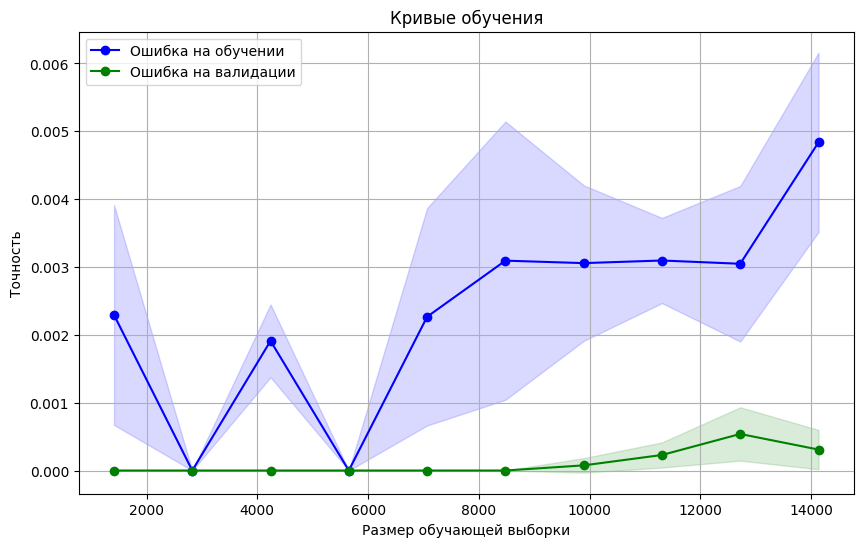

In [ ]:
# RandomForestClassifier
model_rfc_best_par = RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 75, random_state=42)
# Построение кривых обучения
plot_learning_curve(model_rfc_best_par, X_train, y_train_h)

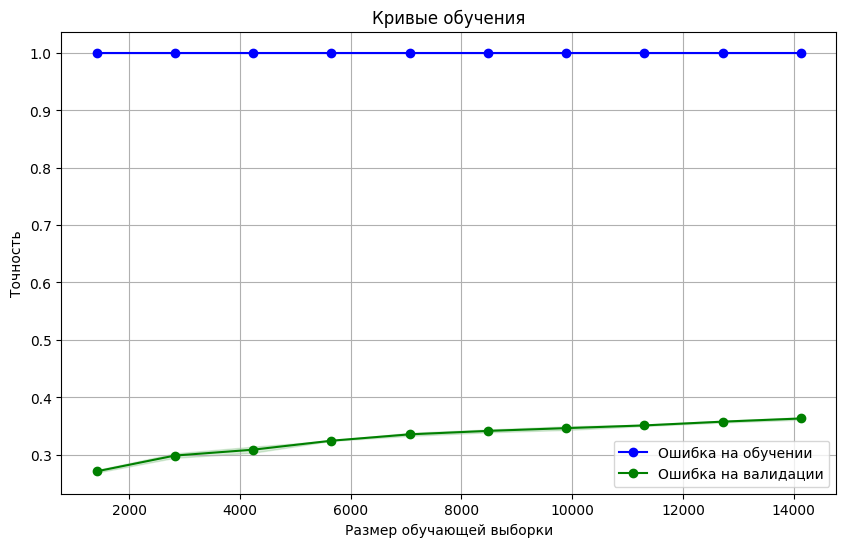

In [ ]:
# KNN
model_knn_best_par = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights= 'distance')
# Построение кривых обучения
plot_learning_curve(model_knn_best_par, X_train, y_train_h)

### Выводы

Выводы: 
- Random Forest - очень плохое качество
- KNN - переобучился 
- CatBoost - требует больших вычислительных мощностей (не получилось)
- DecisionTree - по умолчанию не работает с мультилэйбл классификацией, но можно подкрутить (не успел)


## РЕЙТИНГ

### DecisionTree

In [96]:
from sklearn.tree import DecisionTreeClassifier

In [119]:
model_h_dtc = DecisionTreeClassifier()

# Определение сетки гиперпараметров
param_grid = {
    'max_depth': [3, 5, 10],  # глубина дерева
    'min_samples_split': [2, 5, 10], # min кол-во образцов
    'min_samples_leaf': [1, 2, 4],  # 
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy']    
}

# RandomizeSearchCV
grid_search = RandomizedSearchCV(model_h_dtc, param_grid, cv=cv, scoring='f1_micro', n_jobs=7, verbose=2, n_iter = 10)

grid_search.fit(X_train, y_train_r)  # Обучаем модель на обучающих данных

# 4. Предсказание на тестовых данных
y_pred_r_dtc = grid_search.predict(X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time

In [122]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_r_dtc, y_test_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.4386, 'Recall': 0.4386, 'F1-Score': 0.4386, 'Hamming Loss': 0.5614}
macro - {'Precision': 0.2001, 'Recall': 0.1544, 'F1-Score': 0.1222, 'Hamming Loss': 0.5614}
weighted - {'Precision': 0.9991, 'Recall': 0.4386, 'F1-Score': 0.6094, 'Hamming Loss': 0.5614}


In [120]:
# Лучшая комбинация параметров
best_params_r_dtc = grid_search.best_params_
print("Лучшие параметры:", best_params_r_dtc)

Лучшие параметры: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy'}


In [121]:
# сохранение модели
# Сохранение лучшей комбинации параметров
joblib.dump(best_params_r_dtc, 'best_params_r_dtc.pkl')

['best_params_r_dtc.pkl']

### RandomForest

In [101]:
model_h_rfc = RandomForestClassifier(random_state=42)

In [102]:
# Определение сетки параметров
params = {
    'n_estimators': [5, 10, 15],  # Количество деревьев
    'max_depth': [5, 10, 15],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество samples для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное количество samples в листе
    'max_features': ['sqrt', 'log2'] 
}

# GridSearchCV
grid_search = GridSearchCV(model_h_rfc, params, cv=cv, scoring='f1_micro', n_jobs=6, verbose=2)

grid_search.fit(X_train, y_train_r)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=5; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=5; total time=   0.7

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=6,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 10, 15]},
             scoring='f1_micro', verbose=2)

In [109]:
# Предсказание на тестовой выборке
y_pred_r_rfc = grid_search.predict(X_test)

In [110]:
# Лучшая комбинация параметров
best_params_r_rfc = grid_search.best_params_
print("Лучшие параметры:", best_params_r_rfc)

Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}


In [107]:
# сохранение модели
# Сохранение лучшей комбинации параметров
joblib.dump(best_params_r_rfc, 'best_params_r_rfc.pkl')

['best_params_r_rfc.pkl']

In [111]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_r_rfc, y_test_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.4384, 'Recall': 0.4384, 'F1-Score': 0.4384, 'Hamming Loss': 0.5616}
macro - {'Precision': 0.2, 'Recall': 0.1544, 'F1-Score': 0.1221, 'Hamming Loss': 0.5616}
weighted - {'Precision': 0.9989, 'Recall': 0.4384, 'F1-Score': 0.6093, 'Hamming Loss': 0.5616}


### KNN

In [113]:
# Создание модели KNN
model_knn_r = KNeighborsClassifier()

In [114]:
param_grid = {
    'n_neighbors': list(range(1, 15, 2)),  # Больше значений для n_neighbors
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# GridSearchCV
grid_search = GridSearchCV(model_knn_r, param_grid, cv=cv, scoring='f1_micro', n_jobs=6, verbose=2)

# Обучение модели
grid_search.fit(X_train, y_train_r)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   4.7s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   4.9s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   5.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   5.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   5.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   5.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   4.8s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   4.9s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   5.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   5.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   5.0s
[CV] END ...metric=euclidean, n_neighbors=3, we

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   4.1s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   4.1s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   4.3s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   4.2s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   4.4s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   4.1s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   4.3s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   4.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   3.9s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   4.1s
[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   4.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   4.1s
[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   4.4s
[CV] END ..metric=manhattan, n_neighbors=1, weights=distance; total time=  40.1s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=manhattan, n_neighbors=1, weights=distance; total time=  41.0s
[CV] END ..metric=manhattan, n_neighbors=1, weights=distance; total time=  41.8s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=  41.8s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=  42.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=  41.8s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=  40.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=  40.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=  40.4s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=  40.4s
[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=  40.3s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=  39.8s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  40.8s
[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
 

[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  40.7s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=  40.7s
[CV] END .metric=manhattan, n_neighbors=11, weights=distance; total time=  40.8s
[CV] END ...metric=chebyshev, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=chebyshev, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=chebyshev, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ..metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ...metric=chebyshev, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=chebyshev, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=chebyshev, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=chebyshev,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
42 fits failed out of a total of 126.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro', verbose=2)

In [117]:
# Предсказание на тестовой выборке
y_pred_r_knn = grid_search.predict(X_test)

In [115]:
# Лучшая комбинация параметров
best_params_r_knn = grid_search.best_params_
print("Лучшие параметры:", best_params_r_knn)

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}


In [116]:
# сохранение модели
# Сохранение лучшей комбинации параметров
joblib.dump(best_params_r_knn, 'best_params_r_knn.pkl')

['best_params_r_knn.pkl']

In [118]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = calculate_metrics(y_pred_r_knn, y_test_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.3823, 'Recall': 0.3823, 'F1-Score': 0.3823, 'Hamming Loss': 0.6177}
macro - {'Precision': 0.199, 'Recall': 0.1894, 'F1-Score': 0.1851, 'Hamming Loss': 0.6177}
weighted - {'Precision': 0.5028, 'Recall': 0.3823, 'F1-Score': 0.4244, 'Hamming Loss': 0.6177}


### Проверка переобучения

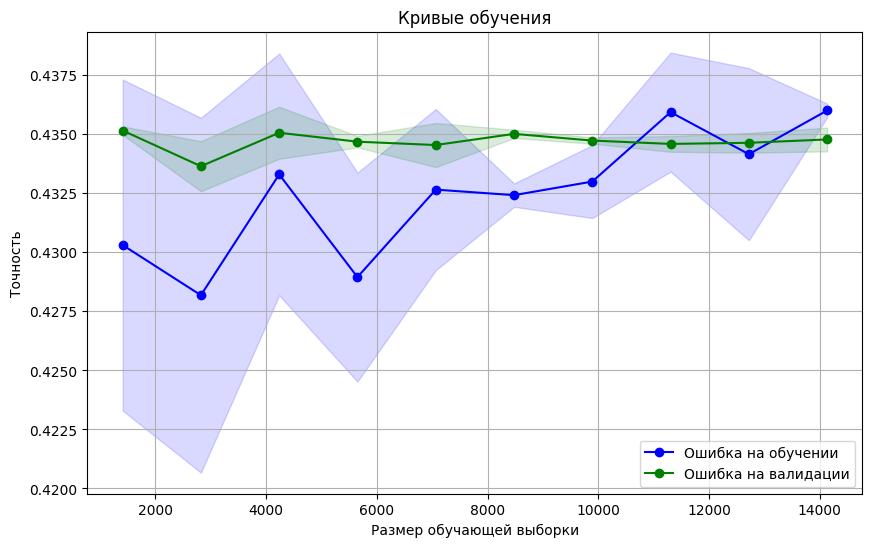

In [123]:
# DecisionTree
model_r_dtc_best_par = DecisionTreeClassifier(max_depth = 3, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, criterion='entropy', random_state=42)
# Построение кривых обучения
plot_learning_curve(model_r_dtc_best_par, X_train, y_train_r)

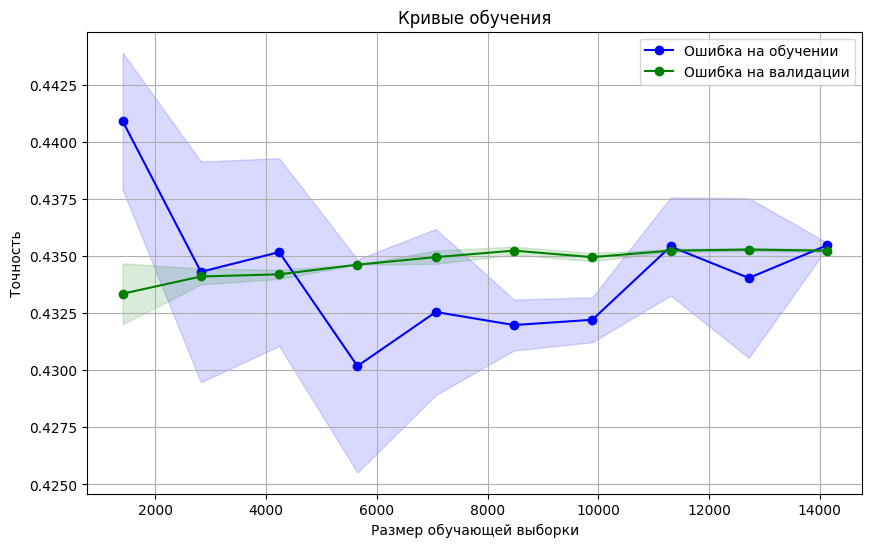

In [125]:
# RandomForest
model_r_rfc_best_par = RandomForestClassifier(max_depth = 10, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, n_estimators=10, criterion='entropy', random_state=42)
# Построение кривых обучения
plot_learning_curve(model_r_rfc_best_par, X_train, y_train_r)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


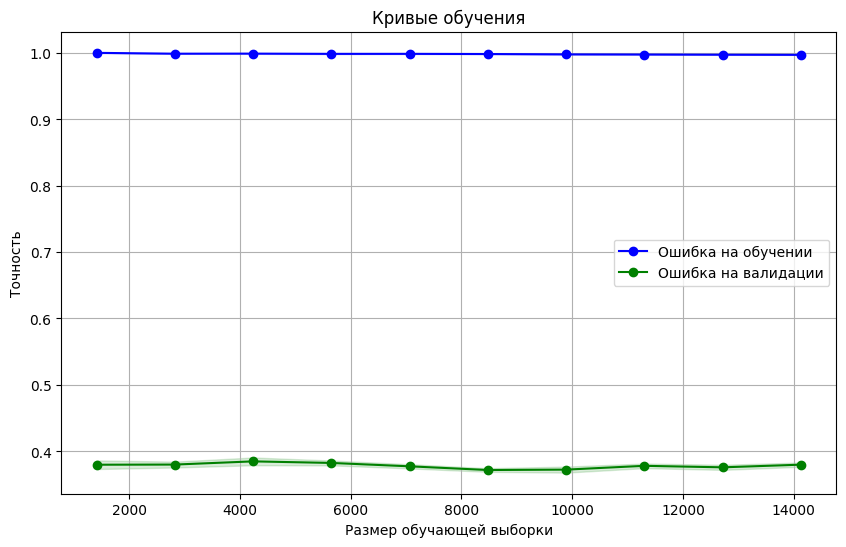

In [128]:
# KNN
model_r_knn_best_par = KNeighborsClassifier(metric='euclidean', n_neighbors=13, weights='distance')
# Построение кривых обучения
plot_learning_curve(model_r_knn_best_par, X_train, y_train_r)

### Выводы

Decision Tree и RandomForest показали одинаковые результаты, оба не переобучились. \
KNN имеет такое же качество не переобучился.

# Выводы

**Хабы** 

Ничего адекватного не вышло

**Рейтинг** 

Лучше всех себя показало Дерево Решений со следующими метриками: 

micro - {'Precision': 0.4386, 'Recall': 0.4386, 'F1-Score': 0.4386, 'Hamming Loss': 0.5614} \
macro - {'Precision': 0.2001, 'Recall': 0.1544, 'F1-Score': 0.1222, 'Hamming Loss': 0.5614} \
weighted - {'Precision': 0.9991, 'Recall': 0.4386, 'F1-Score': 0.6094, 'Hamming Loss': 0.5614}